In [1]:
import os
import sys
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sys.path.append('/home/mingot/lung_cancer_ds_bowl/src')
from utils import plotting

wp = '/home/mingot/lung_cancer_ds_bowl/'
wp2 = '/mnt/hd2/preprocessed5/'
sys.path.append('/home/mingot/lung_cancer_ds_bowl/src')

# Paths and files
#nodules_df  = pd.read_csv("/home/mingot/output/noduls_patches_v04_dsb.csv")
annotations_df = pd.read_csv("/home/shared/data/luna/annotations.csv")
patients_annotated = ["luna_%s.npz" % p.split('.')[-1] for p in list(set(annotations_df['seriesuid']))]
print "%d patients annotated in LUNA" % len(patients_annotated)


601 patients annotated in LUNA


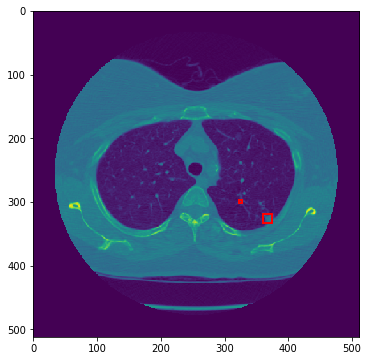

In [53]:
## CSV visualization or simple 

def visualize_csv(img, node_df):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    for idx,row in node_df.iterrows():
        cx = row['x']  # row
        cy = row['y']  # column
        r = int(math.ceil(row['diameter']/2.))
        minr, minc, maxr, maxc = cx-r, cy-r, cx+r+1, cy+r+1
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    plt.show()


filename, nslice = 'luna_112740418331256326754121315800.npz', 126-96  # Ben detectat
patient_data = np.load('/mnt/hd2/preprocessed5/' + filename)['arr_0']
sel_nodules_df = nodules_df[(nodules_df['filename']==filename) & (nodules_df['score']>0.8)]
sel_nodules_df[sel_nodules_df['nslice']==nslice]

visualize_csv(patient_data[0,nslice], sel_nodules_df[sel_nodules_df['nslice']==nslice])

In [ ]:
# visualize nodules and lung segmenation
reload(plotting)
wp = '/mnt/hd2/preprocessed5/'
filename = random.choice(patients_annotated)
#filename = 'dsb_799b283083f1b6547d558f063b318e78.npz'

p = np.load(wp+filename)['arr_0']
print "Patient: %s, shape: %s" % (filename, str(p.shape))

slices = plotting.slices_with_nodules(p[2])
print "Slices with nodules:", slices

new_slices = set()  # add previous and former slices
for nslice in slices:
    new_slices.update(range(nslice-1,nslice+2))

new_slices = list(new_slices)
new_slices.sort()    
print "New slices:", new_slices


for nslice in new_slices:
    voxel_volume_l = 2*0.7*0.7/(1000000.0)
    print "Slice:%d, Lung Volume:%s" % (nslice, str(np.sum(p[1,nslice])*voxel_volume_l))
    plotting.plot_mask(p[0,nslice], p[2,nslice])
    #plotting.plot_mask(p[1,nslice], p[2,nslice])

1.3.6.1.4.1.14519.5.2.1.6279.6001.241717018262666382493757419144
                                             seriesuid     coordX     coordY  \
581  1.3.6.1.4.1.14519.5.2.1.6279.6001.241717018262...  31.351537  49.993503   
582  1.3.6.1.4.1.14519.5.2.1.6279.6001.241717018262...  84.469965  54.580911   

         coordZ  diameter_mm  
581  -93.090190     9.953170  
582 -216.189268     4.257333  
Slice rad for nodule 581: 3 (diam: 9.953, spacing:0.851562023163)
Slice rad for nodule 582: 1 (diam: 4.257, spacing:0.851562023163)
Slices with nodules: [74, 75, 76, 171, 172, 173, 174, 175, 176, 177]
New slices: [73, 74, 75, 76, 77, 170, 171, 172, 173, 174, 175, 176, 177, 178]
Slice: 73


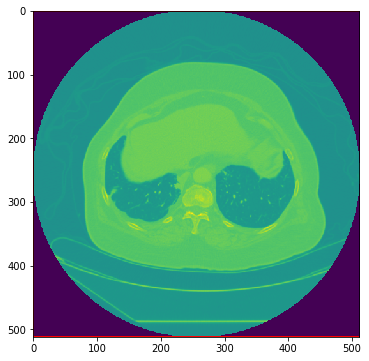

Slice: 74


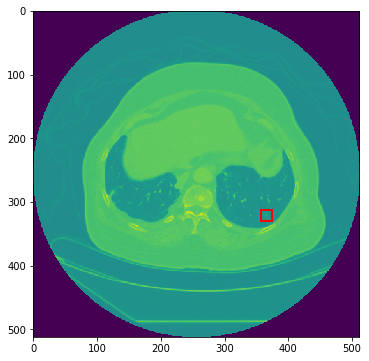

Slice: 75


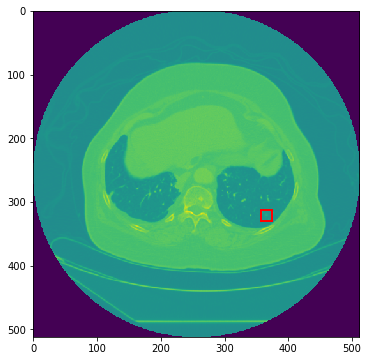

Slice: 76


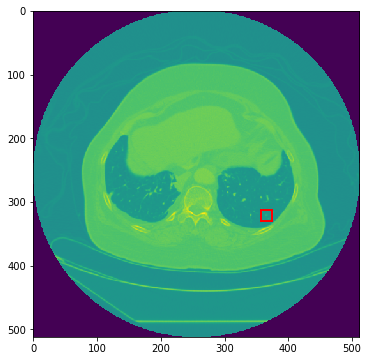

Slice: 77


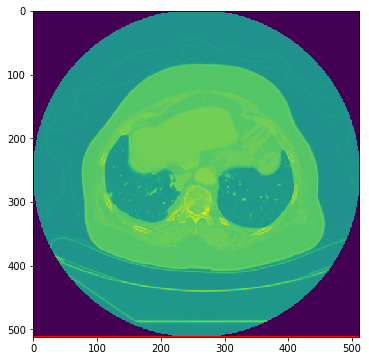

Slice: 170


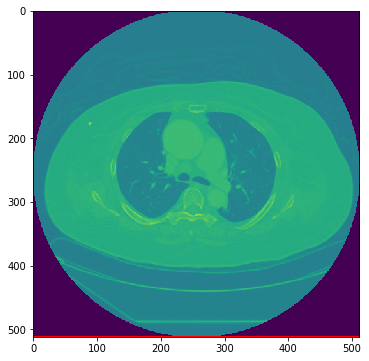

Slice: 171


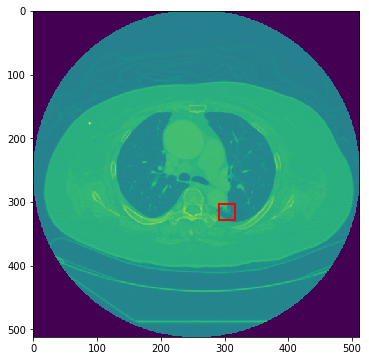

Slice: 172


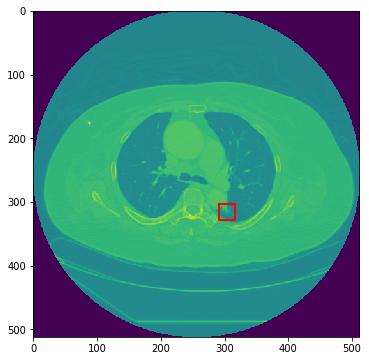

Slice: 173


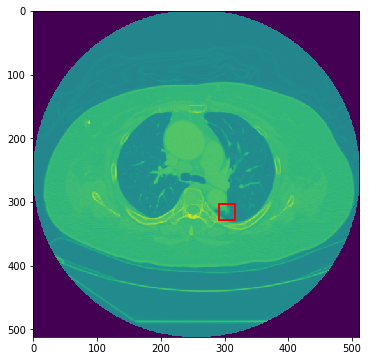

Slice: 174


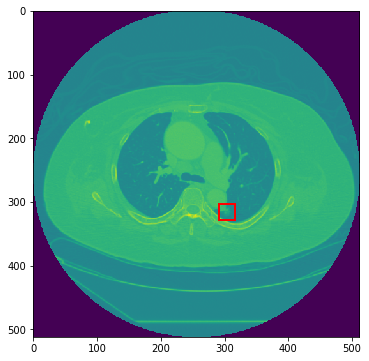

Slice: 175


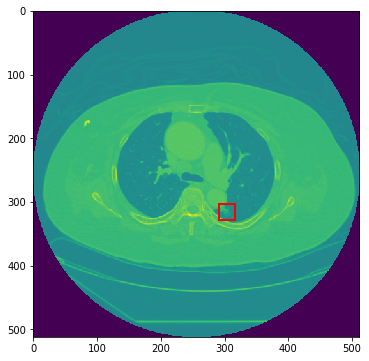

Slice: 176


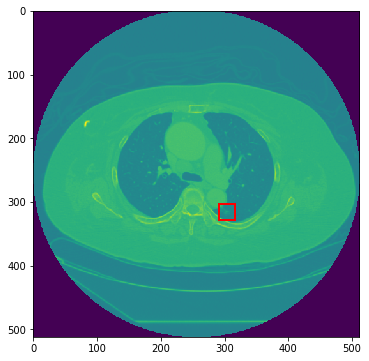

Slice: 177


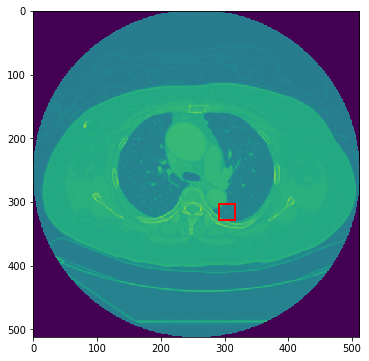

Slice: 178


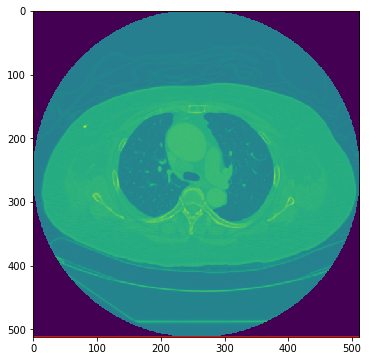

NameError: name 'preprocessing' is not defined

In [34]:
import SimpleITK as sitk
from skimage.draw import circle

def create_mask(img, nodules):

    if len(nodules) == 0:
        return None

    height, width, num_z = img.GetSize()
    masks = np.zeros([num_z, height, width], dtype=np.uint8)
    origin = np.array(img.GetOrigin())  # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(img.GetSpacing())  # spacing of voxels in world coor. (mm)

    # row = nodules.iloc[0]
    for index, row in nodules.iterrows():
        node_x = row["coordX"]
        node_y = row["coordY"]
        node_z = row["coordZ"]
        diam = row["diameter_mm"]
        center = np.array([node_x, node_y, node_z])  # nodule center
        v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space

        if v_center[0]<0 and v_center[1]<0:  # fix for when the origin invert the coordinates
            v_center[0] = -v_center[0]
            v_center[1] = -v_center[1]
            changed = True
        
        slice_rad = int(int(diam/2)/spacing[2])
        print "Slice rad for nodule %d: %d (diam: %.3f, spacing:%s)" % (index, slice_rad, diam, str(spacing[0]))
        for i_z in range(int(v_center[2])-slice_rad,int(v_center[2])+slice_rad + 1):

            new_mask = np.zeros([height, width], dtype=np.uint8)
            rr, cc = circle(v_center[1], v_center[0], int(diam/spacing[0]+15)/2)
            new_mask[rr, cc] = 1

            masks[i_z, :, :] = np.bitwise_or(masks[i_z, :, :], new_mask)

    return masks

# BIG: 1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804
# BIG: 1.3.6.1.4.1.14519.5.2.1.6279.6001.163901773171373940247829492387
# molts petits: 1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703233250639913775427
# radi massa gran en alguns: 1.3.6.1.4.1.14519.5.2.1.6279.6001.168985655485163461062675655739
seriesuid = random.choice(list(set(annotations_df['seriesuid'])))
print seriesuid

patient = sitk.ReadImage('/home/shared/data/luna/images/%s.mhd' % seriesuid) 
lung_image = sitk.GetArrayFromImage(patient)  # indexes are z,y,x
nodules = annotations_df[annotations_df["seriesuid"] == seriesuid]  # filter nodules for patient

print nodules
nodule_mask = create_mask(img=patient, nodules=nodules)
slices = plotting.slices_with_nodules(nodule_mask)
print "Slices with nodules:", slices

new_slices = set()  # add previous and former slices
for nslice in slices:
    new_slices.update(range(nslice-1,nslice+2))

new_slices = list(new_slices)
new_slices.sort()  
print "New slices:", new_slices

for nslice in new_slices:
    print 'Slice:', nslice
    plotting.plot_mask(lung_image[nslice], nodule_mask[nslice])


# resampling and cropping
COMMON_SPACING = [2, 0.7, 0.7]
nodule_mask, new_spacing = preprocessing.resample(nodule_mask, spacing=originalSpacing, new_spacing=COMMON_SPACING)
nodule_mask = preprocessing.resize_image(nodule_mask, size=512)

NameError: name 'np' is not defined